In [ ]:
from Bio import SeqIO

def read_fasta(file_path):
    sequences = {}
    for record in SeqIO.parse(file_path, "fasta"):
        sequences[record.id] = str(record.seq)
    return sequences

train_sequences = read_fasta("Dataset/all.train.fasta")
test_sequences = read_fasta("Dataset/all.test.fasta")

for key, value in list(train_sequences.items())[:5]:
    print(f"Protein ID: {key}\nSequence: {value}\n")

Protein ID: non-allergen_3154
Sequence: MAAHTILASAPSHTTFSLISPFSSTPTNALSSSLQSSSFNGLSFKLSPTTQSLSLSTSAASKPLTIVAATKKAVAVLKGTSNVEGVVTLTQEDDGPTTVNVRISGLAPGKHGFHLHEFGDTTNGCMSTGPHFNPDKKTHGAPEDEVRHAGDLGNIVANTDGVAEATIVDNQIPLTGPNSVVGRALVVHELEDDLGKGGHELSPTTGNAGGRLACGVVGLTPV

Protein ID: non-allergen_2914
Sequence: MAQFLRLCIWLLALGSCLLATVQADCSQDCAKCSYRLVRPGDINFLACTLECEGQLPSFKIWETCKDLLQVSKPEFPWDNIDMYKDSSKQDESHLLAKKYGGFMKRYGGFMKKMDELYPVEPEEEANGGEILAKRYGGFMKKDADEGDTLANSSDLLKELLGTGDNRAKDSHQQESTNNDEDSTSKRYGGFMRGLKRSPQLEDEAKELQKRYGGFMRRVGRPEWWMDYQKRYGGFLKRFAESLPSDEEGESYSKEVPEMEKRYGGFMRF

Protein ID: non-allergen_19622
Sequence: MSSTTQAPEPVYQWTADEAVQFLKEWNFSLGIILLFITIILQFGYTSRSMFIYVVKMIILWLMWPLTIVLCIFNCVYALNNVYLGFSIVFTIVSIVIWIMYFVNSIRLFIRTGSWWSFNPETNNLMCIDMKGTVYVRPIIEDYHTLTATIIRGHLYMQGVKLGTGFSLSDLPAYVTVAKVSHLCTYKRAFLDKVDGVSGFAVYVKSKVGNYRLPSNKPSGADTALLRI

Protein ID: allergen_2182
Sequence: MSWQAYVDDHLMCEIEGTNNHLTAAAILGVDGSVWAQSANFPQFKPDEISAVVKEFDEAGTLAPTGLHLGGTKYMVIQSEAGQVIRGKKGPGGICVKKTGQALIFGIYDEPVTPGQCN

In [4]:
from Bio import SeqIO
import pandas as pd

def read_fasta_with_labels(file_path):
    data = []
    
    for record in SeqIO.parse(file_path, "fasta"):
        protein_id = record.id

        sequence = str(record.seq)

        label = 0 if "non-allergen" in protein_id else 1
        
        data.append([protein_id, sequence, label])

    df = pd.DataFrame(data, columns=["Protein_ID", "Sequence", "Label"])
    
    return df

train_df = read_fasta_with_labels("Dataset/all.train.fasta")
test_df = read_fasta_with_labels("Dataset/all.test.fasta")

print(train_df.head())

           Protein_ID                                           Sequence   
0   non-allergen_3154  MAAHTILASAPSHTTFSLISPFSSTPTNALSSSLQSSSFNGLSFKL...  \
1   non-allergen_2914  MAQFLRLCIWLLALGSCLLATVQADCSQDCAKCSYRLVRPGDINFL...   
2  non-allergen_19622  MSSTTQAPEPVYQWTADEAVQFLKEWNFSLGIILLFITIILQFGYT...   
3       allergen_2182  MSWQAYVDDHLMCEIEGTNNHLTAAAILGVDGSVWAQSANFPQFKP...   
4  non-allergen_40251  MNLFVYIAQNPTLTKWFFCCVCTILTMPFFKKPYRKRGISRTPYEW...   

   Label  
0      0  
1      0  
2      0  
3      1  
4      0  


In [6]:
train_df["Tokenized_Sequence"] = train_df["Sequence"].apply(lambda x: " ".join(list(x)))
test_df["Tokenized_Sequence"] = test_df["Sequence"].apply(lambda x: " ".join(list(x)))

print(train_df[["Protein_ID", "Tokenized_Sequence", "Label"]].head())

           Protein_ID                                 Tokenized_Sequence   
0   non-allergen_3154  M A A H T I L A S A P S H T T F S L I S P F S ...  \
1   non-allergen_2914  M A Q F L R L C I W L L A L G S C L L A T V Q ...   
2  non-allergen_19622  M S S T T Q A P E P V Y Q W T A D E A V Q F L ...   
3       allergen_2182  M S W Q A Y V D D H L M C E I E G T N N H L T ...   
4  non-allergen_40251  M N L F V Y I A Q N P T L T K W F F C C V C T ...   

   Label  
0      0  
1      0  
2      0  
3      1  
4      0  


In [10]:
train_df.to_csv("Dataset/processed_for_bert_train.csv", index=False)
test_df.to_csv("Dataset/processed_for_bert_test.csv", index=False)

In [11]:
import torch
from transformers import BertTokenizer, BertModel

# ProtBERT tokenizer & model
tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
model = BertModel.from_pretrained("Rostlab/prot_bert")

# maybe we need to use colab
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)

print("ProtBERT Model Loaded")

/opt/homebrew/Caskroom/miniconda/base/envs/protein_allergy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ProtBERT Model Loaded


In [12]:
def get_protbert_embeddings(sequence):

    inputs = tokenizer(sequence, return_tensors="pt", padding=True, truncation=True)

    inputs = {key: value for key, value in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
    
    # last hidden layer (shape: [1, sequence_length, 1024])
    last_hidden_state = outputs.last_hidden_state

    embedding = last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

    return embedding  # Shape: (1024,)

In [9]:
import numpy as np
from tqdm import tqdm

train_df["Tokenized_Sequence"] = train_df["Sequence"].apply(lambda x: " ".join(list(x)))

embeddings = []

for seq in tqdm(train_df["Tokenized_Sequence"]):
    emb = get_protbert_embeddings(seq)
    embeddings.append(emb)

embeddings_array = np.array(embeddings)

np.save("protbert_train_embeddings.npy", embeddings_array)

print("ProtBERT embeddings Shape:", embeddings_array.shape)

100%|██████████| 5680/5680 [45:25<00:00,  2.08it/s]  

ProtBERT embeddings Shape: (5680, 1024)


In [10]:
embedding_df = pd.DataFrame(embeddings_array)
embedding_df["Label"] = train_df["Label"]  

embedding_df.to_csv("Dataset/protbert_train_embeddings.csv", index=False)
print("Embeddings saved")

Embeddings saved


In [11]:
print(embedding_df.head())

          0         1         2         3         4         5         6   
0  0.086905  0.064474 -0.012450 -0.037899  0.003578 -0.016869  0.031366  \
1  0.067527 -0.009051 -0.007344 -0.038439  0.023209  0.011579  0.001814   
2  0.106294  0.020479  0.037305  0.009191  0.064401  0.007766  0.004668   
3  0.010107  0.028703 -0.031847 -0.042281  0.062848 -0.029239  0.010851   
4  0.003830 -0.030011  0.043521 -0.019920 -0.036928 -0.006020 -0.007284   

          7         8         9  ...      1015      1016      1017      1018   
0  0.044413 -0.022268 -0.013294  ...  0.014594  0.015101 -0.033381 -0.023159  \
1  0.032845  0.027436  0.008903  ... -0.005045  0.034608 -0.091185 -0.030919   
2  0.011003  0.040737 -0.009711  ... -0.004814  0.022652  0.000608 -0.045922   
3  0.019762  0.009444  0.031312  ...  0.020512  0.035028 -0.004533 -0.044993   
4 -0.016183 -0.008275  0.007242  ...  0.031610 -0.044113 -0.031392  0.020649   

       1019      1020      1021      1022      1023  Label  
0 -0.00

In [12]:
print(embedding_df.shape)

(5680, 1025)


In [13]:
print(embedding_df.iloc[0])

0        0.086905
1        0.064474
2       -0.012450
3       -0.037899
4        0.003578
           ...   
1020    -0.073165
1021    -0.049568
1022     0.002033
1023     0.016894
Label    0.000000
Name: 0, Length: 1025, dtype: float64


In [14]:
print(embedding_df.iloc[0, :-1])

0       0.086905
1       0.064474
2      -0.012450
3      -0.037899
4       0.003578
          ...   
1019   -0.003469
1020   -0.073165
1021   -0.049568
1022    0.002033
1023    0.016894
Name: 0, Length: 1024, dtype: float64


In [15]:
print(embedding_df["Label"].value_counts())

Label
0    2840
1    2840
Name: count, dtype: int64


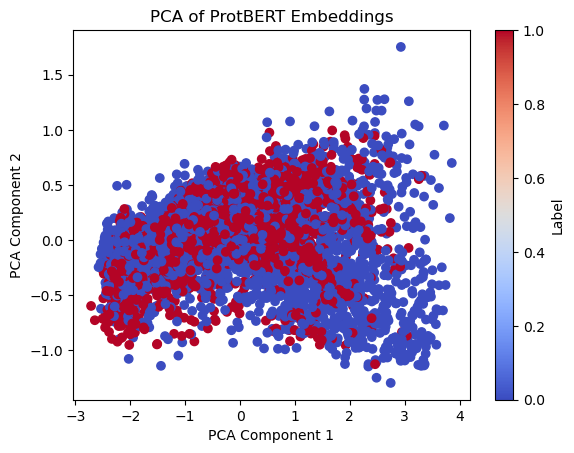

In [16]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embedding_df.iloc[:, :-1])  

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=embedding_df["Label"], cmap='coolwarm')
plt.title("PCA of ProtBERT Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Label")
plt.show()

In [17]:
test_df["Tokenized_Sequence"] = test_df["Sequence"].apply(lambda x: " ".join(list(x)))

print(test_df[["Protein_ID", "Tokenized_Sequence", "Label"]].head())

      Protein_ID                                 Tokenized_Sequence  Label
0  allergen_2145  M V K N L P P S V R E Q C I E S Q I V I R D C ...      1
1   allergen_109  M K F F A V L A L C I V G A I A S P L T A D E ...      1
2  allergen_2419  M S K A R V Y T D V N V L R P K E Y W D Y E A ...      1
3    allergen_12  M A K L V L S L C F L L F S G C C F A F S F R ...      1
4   allergen_117  M K I V L A I A S L L A L S A V Y A R P S S I ...      1


In [14]:
import numpy as np
from tqdm import tqdm

test_df["Tokenized_Sequence"] = test_df["Sequence"].apply(lambda x: " ".join(list(x)))

embeddings = []

for seq in tqdm(test_df["Tokenized_Sequence"]):
    emb = get_protbert_embeddings(seq)
    embeddings.append(emb)

embeddings_array = np.array(embeddings)

np.save("protbert_test_embeddings.npy", embeddings_array)

print("ProtBERT embeddings Shape:", embeddings_array.shape)

100%|██████████| 1420/1420 [12:49<00:00,  1.85it/s]

ProtBERT embeddings Shape: (1420, 1024)


In [27]:
embedding_df = pd.DataFrame(embeddings_array)
embedding_df["Label"] = test_df["Label"]  

embedding_df.to_csv("Dataset/protbert_test_embeddings.csv", index=False)
print("Embeddings saved")

Embeddings saved


In [45]:
train_label_counts = train_df["Label"].value_counts()
print("Train Set Label Distribution:")
print(train_label_counts)

test_label_counts = test_df["Label"].value_counts()
print("\nTest Set Label Distribution:")
print(test_label_counts)

Train Set Label Distribution:
Label
0    2840
1    2840
Name: count, dtype: int64

Test Set Label Distribution:
Label
0    715
1    705
Name: count, dtype: int64


In [29]:
print(train_df.duplicated().sum(), test_df.duplicated().sum())

0 0


In [30]:
print(train_df.columns)
print(test_df.columns)

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023',
       'Label'],
      dtype='object', length=1025)
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '1015', '1016', '1017', '1018', '1019', '1020', '1021', '1022', '1023',
       'Label'],
      dtype='object', length=1025)


In [31]:
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,1015,1016,1017,1018,1019,1020,1021,1022,1023,Label
0,0.086905,0.064474,-0.012450,-0.037899,0.003578,-0.016869,0.031366,0.044413,-0.022268,-0.013294,...,0.014594,0.015101,-0.033381,-0.023159,-0.003469,-0.073165,-0.049568,0.002033,0.016894,0
1,0.067527,-0.009051,-0.007344,-0.038439,0.023209,0.011579,0.001814,0.032845,0.027436,0.008903,...,-0.005045,0.034608,-0.091185,-0.030919,-0.043191,-0.052509,-0.061765,0.025321,0.001051,0
2,0.106294,0.020479,0.037305,0.009191,0.064401,0.007766,0.004668,0.011003,0.040737,-0.009711,...,-0.004814,0.022652,0.000608,-0.045922,-0.037261,-0.057934,-0.036676,-0.045970,-0.019217,0
3,0.010107,0.028703,-0.031847,-0.042281,0.062848,-0.029239,0.010851,0.019762,0.009444,0.031312,...,0.020512,0.035028,-0.004533,-0.044993,-0.049837,-0.053299,-0.055925,-0.010627,0.023868,1
4,0.003830,-0.030011,0.043521,-0.019920,-0.036928,-0.006020,-0.007284,-0.016183,-0.008275,0.007242,...,0.031610,-0.044113,-0.031392,0.020649,0.007634,0.008333,0.009560,-0.002700,0.064265,0


In [32]:
train_df_processed = pd.read_csv("Dataset/processed_for_bert_train.csv")
test_df_processed = pd.read_csv("Dataset/processed_for_bert_test.csv")

In [33]:
overlap = set(train_df_processed["Sequence"]).intersection(set(test_df_processed["Sequence"]))
print(f"Number of overlapping sequences: {len(overlap)}")

Number of overlapping sequences: 0


In [34]:
train_df_processed.columns

Index(['Protein_ID', 'Sequence', 'Label', 'Tokenized_Sequence'], dtype='object')

### Get Base Results with KNN/Logistic Regression/SVM etc. ###

In [35]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

train_embeddings = np.load("Dataset/protbert_train_embeddings.npy")

train_df = pd.read_csv("Dataset/protbert_train_embeddings.csv")
train_labels = train_df["Label"].values  # Extract labels

#scaler = StandardScaler()
#train_embeddings = scaler.fit_transform(train_embeddings)

log_reg = LogisticRegression()
log_reg.fit(train_embeddings, train_labels)

print("Logistic Regression model trained")

Logistic Regression model trained


/opt/homebrew/Caskroom/miniconda/base/envs/protein_allergy/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
test_embeddings = np.load("Dataset/protbert_test_embeddings.npy")

#test_embeddings = scaler.transform(test_embeddings) 

test_df = pd.read_csv("Dataset/protbert_test_embeddings.csv")  
test_labels = test_df["Label"].values  

test_predictions = log_reg.predict(test_embeddings)

accuracy = accuracy_score(test_labels, test_predictions)
print(f"Test Accuracy: {accuracy:.4f}")

print(classification_report(test_labels, test_predictions))

Test Accuracy: 0.4746
              precision    recall  f1-score   support

           0       0.48      0.48      0.48       715
           1       0.47      0.47      0.47       705

    accuracy                           0.47      1420
   macro avg       0.47      0.47      0.47      1420
weighted avg       0.47      0.47      0.47      1420



In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

train_embeddings = np.load("Dataset/protbert_train_embeddings.npy")
test_embeddings = np.load("Dataset/protbert_test_embeddings.npy")

train_df = pd.read_csv("Dataset/protbert_train_embeddings.csv")
test_df = pd.read_csv("Dataset/protbert_test_embeddings.csv")  # Adjust if needed

train_labels = train_df["Label"].values
test_labels = test_df["Label"].values


models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB()
}

for name, model in models.items():
    model.fit(train_embeddings, train_labels)
    predictions = model.predict(test_embeddings)
    accuracy = accuracy_score(test_labels, predictions)
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(test_labels, predictions))
    print("-" * 50)

/opt/homebrew/Caskroom/miniconda/base/envs/protein_allergy/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.4746
              precision    recall  f1-score   support

           0       0.48      0.48      0.48       715
           1       0.47      0.47      0.47       705

    accuracy                           0.47      1420
   macro avg       0.47      0.47      0.47      1420
weighted avg       0.47      0.47      0.47      1420

--------------------------------------------------
SVM Accuracy: 0.4732
              precision    recall  f1-score   support

           0       0.48      0.47      0.48       715
           1       0.47      0.47      0.47       705

    accuracy                           0.47      1420
   macro avg       0.47      0.47      0.47      1420
weighted avg       0.47      0.47      0.47      1420

--------------------------------------------------
Random Forest Accuracy: 0.4796
              precision    recall  f1-score   support

           0       0.48      0.50      0.49       715
           1       0.48      0.46      0.47   

/opt/homebrew/Caskroom/miniconda/base/envs/protein_allergy/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [17:23:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.4761
              precision    recall  f1-score   support

           0       0.48      0.47      0.48       715
           1       0.47      0.48      0.48       705

    accuracy                           0.48      1420
   macro avg       0.48      0.48      0.48      1420
weighted avg       0.48      0.48      0.48      1420

--------------------------------------------------
KNN Accuracy: 0.4739
              precision    recall  f1-score   support

           0       0.48      0.46      0.47       715
           1       0.47      0.49      0.48       705

    accuracy                           0.47      1420
   macro avg       0.47      0.47      0.47      1420
weighted avg       0.47      0.47      0.47      1420

--------------------------------------------------
Naive Bayes Accuracy: 0.4768
              precision    recall  f1-score   support

           0       0.48      0.38      0.42       715
           1       0.48      0.58      0.52       705

    a

In [38]:
print("Train embeddings shape:", train_embeddings.shape)
print("Train labels shape:", train_labels.shape)
print("Test embeddings shape:", test_embeddings.shape)
print("Test labels shape:", test_labels.shape)

Train embeddings shape: (5680, 1024)
Train labels shape: (5680,)
Test embeddings shape: (1420, 1024)
Test labels shape: (1420,)


In [39]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

train_embeddings = np.load("Dataset/protbert_train_embeddings.npy")
test_embeddings = np.load("Dataset/protbert_test_embeddings.npy")

train_labels = train_df["Label"].values
test_labels = test_df["Label"].values

def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    
    print(f"Model: {model_name}")
    print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
    print(f"Test accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if auc:
        print(f"AUC-ROC: {auc:.4f}")
    print("-" * 50)
    
    return {
        "model": model_name,
        "cv_accuracy": cv_scores.mean(),
        "test_accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc
    }

results = []

# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
results.append(evaluate_model(knn, train_embeddings, train_labels, test_embeddings, test_labels, "KNN"))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
results.append(evaluate_model(rf, train_embeddings, train_labels, test_embeddings, test_labels, "Random Forest"))

# Support Vector Machine
svm = SVC(probability=True, random_state=42)
results.append(evaluate_model(svm, train_embeddings, train_labels, test_embeddings, test_labels, "SVM"))

results_df = pd.DataFrame(results)
results_df.to_csv("baseline_results.csv", index=False)

Model: KNN
Cross-validation accuracy: 0.9139 ± 0.0078
Test accuracy: 0.4739
Precision: 0.4712
Recall: 0.4879
F1 Score: 0.4794
AUC-ROC: 0.4764
--------------------------------------------------
Model: Random Forest
Cross-validation accuracy: 0.9345 ± 0.0044
Test accuracy: 0.4817
Precision: 0.4774
Recall: 0.4638
F1 Score: 0.4705
AUC-ROC: 0.4887
--------------------------------------------------
Model: SVM
Cross-validation accuracy: 0.9194 ± 0.0121
Test accuracy: 0.4732
Precision: 0.4697
Recall: 0.4723
F1 Score: 0.4710
AUC-ROC: 0.4858
--------------------------------------------------


### Visualize Example AlphaFold 3D Structure ###


In [ ]:
from Bio.PDB import PDBParser
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def visualize_pdb(file_path):
    parser = PDBParser()
    structure = parser.get_structure("protein", file_path)

    coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    coords.append(residue['CA'].get_coord())

    coords = np.array(coords)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='b', marker='o')
    ax.set_title("3D Visualization of Protein Structure")
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_zlabel("Z-axis")
    plt.show()


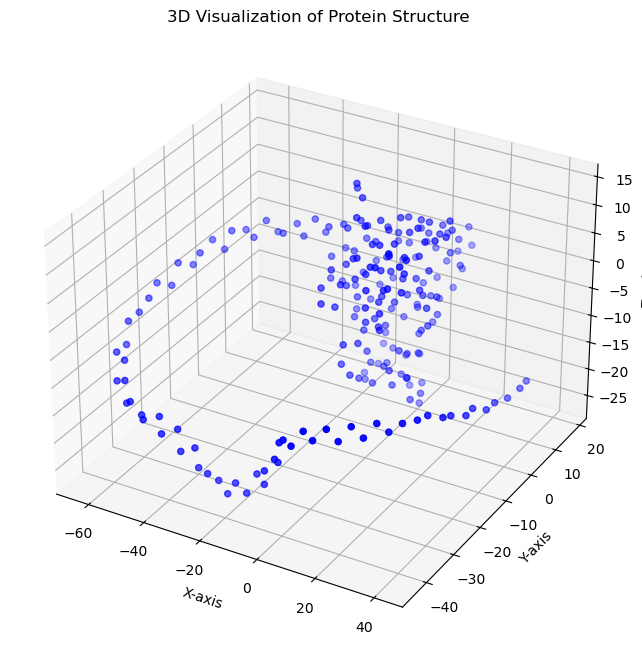

In [41]:
pdb_file_path = "AlphaFold/test_8c970/test_8c970_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb"
visualize_pdb(pdb_file_path)

In [44]:
import py3Dmol
import IPython.display as display

view = py3Dmol.view(width=800, height=600)
with open("AlphaFold/test_8c970/test_8c970_unrelaxed_rank_001_alphafold2_ptm_model_1_seed_000.pdb") as f:
    pdb_data = f.read()
view.addModel(pdb_data, "pdb")
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [46]:
import py3Dmol
import IPython.display as display

view = py3Dmol.view(width=800, height=600)
with open("AlphaFold/test_8c970/test_8c970_unrelaxed_rank_002_alphafold2_ptm_model_2_seed_000.pdb") as f:
    pdb_data = f.read()
view.addModel(pdb_data, "pdb")
view.setStyle({'cartoon': {'color': 'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

### Create example graph for example protein sequence for test purposes ###

Residue id: 1
Residue name: LYS
Coords of atom: [-8.297  3.514  6.371]
Residue id: 2
Residue name: GLY
Coords of atom: [-9.047  1.143  3.43 ]
Residue id: 3
Residue name: PHE
Coords of atom: [-6.145 -1.463  3.164]
Residue id: 4
Residue name: MET
Coords of atom: [-4.648 -1.068 -0.324]
Residue id: 5
Residue name: THR
Coords of atom: [-4.273 -4.438 -1.992]
Residue id: 6
Residue name: PRO
Coords of atom: [-0.857 -5.562 -3.021]
Residue id: 7
Residue name: GLU
Coords of atom: [-2.104 -5.492 -6.555]
Residue id: 8
Residue name: ARG
Coords of atom: [-2.83  -1.816 -6.387]
Residue id: 9
Residue name: ALA
Coords of atom: [ 0.588 -1.115 -4.668]
Residue id: 10
Residue name: ALA
Coords of atom: [ 2.365 -2.838 -7.5  ]
Residue id: 11
Residue name: GLU
Coords of atom: [  0.569  -0.635 -10.039]
Residue id: 12
Residue name: PHE
Coords of atom: [ 1.859  2.59  -8.32 ]
Residue id: 13
Residue name: ASN
Coords of atom: [ 5.512  1.331 -8.234]
Residue id: 14
Residue name: PHE
Coords of atom: [  5.695   0.671 -12.

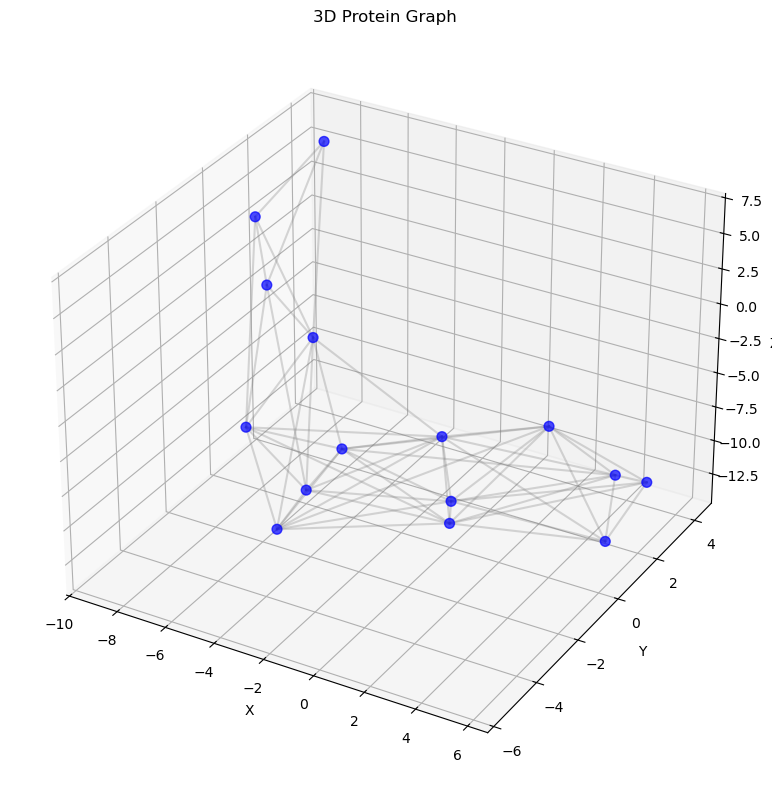

Number of nodes: 15
Number of edges: 54
Average degree: 7.20


In [ ]:
import networkx as nx
from Bio.PDB import PDBParser
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def create_protein_graph(pdb_file, distance_threshold=10.0):

    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("protein", pdb_file)

    G = nx.Graph()
    
    residue_list = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if 'CA' in residue:
                    residue_id = residue.get_id()[1]  # Residue number
                    print(f"Residue id: {residue_id}")
                    residue_name = residue.get_resname()  # Amino acid type from Bio.PDB.Residue API
                    print(f"Residue name: {residue_name}")
                    coords = residue['CA'].get_coord()  # CA atom coordinates
                    print(f"Coords of atom: {coords}")
              
                    G.add_node(residue_id, 
                              residue_name=residue_name,
                              coords=coords,
                              position=residue_id)  # Position in sequence
                    
                    residue_list.append((residue_id, coords))

    for i, (res_i, coord_i) in enumerate(residue_list):
        for j, (res_j, coord_j) in enumerate(residue_list[i+1:], i+1):
            distance = np.linalg.norm(coord_i - coord_j) # Manhattan Distance between different amino acids based on a threshold
            print(f"Distance: {distance}")
            if distance < distance_threshold:
                G.add_edge(res_i, res_j, weight=distance)
    
    return G, residue_list

def visualize_protein_graph(G, residue_list):
    coords = np.array([coord for _, coord in residue_list])

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='blue', s=50, alpha=0.7)
    
    for u, v in G.edges():
        coord_u = G.nodes[u]['coords']
        coord_v = G.nodes[v]['coords']
        ax.plot([coord_u[0], coord_v[0]], 
                [coord_u[1], coord_v[1]], 
                [coord_u[2], coord_v[2]], 'gray', alpha=0.3)
    
    ax.set_title("3D Protein Graph")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.tight_layout()
    plt.show()
    
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")

pdb_file_path = "allergen_3552_unrelaxed_rank_004_alphafold2_ptm_model_1_seed_000.pdb"
G, residue_list = create_protein_graph(pdb_file_path)
visualize_protein_graph(G, residue_list)

In [54]:
from transformers import BertTokenizer, BertModel
import torch

def create_protein_graph_with_embedding(pdb_file, embedding, distance_threshold=10.0):

    G.graph['embedding'] = embedding
    
    return G, residue_list


def get_protbert_embeddings(sequence):
    tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)
    model = BertModel.from_pretrained("Rostlab/prot_bert")
    
    tokenized_seq = " ".join(list(sequence))
    inputs = tokenizer(tokenized_seq, return_tensors="pt", padding=True, truncation=True)
    
    with torch.no_grad():
        outputs = model(**inputs)

    last_hidden_state = outputs.last_hidden_state
    embedding = last_hidden_state.mean(dim=1).squeeze().cpu().numpy()
    
    return embedding

In [55]:

protein_sequence = "MSAQPVDIQIFGRSLRVNCPPDQRDALNQAADDLNQRLQDLKERTRVTNTEQLVFIAALNISYELAQEKAKTRDYAASMEQRIRMLQQTIEQALLEQGRITEKTNQNFE"  
embedding = get_protbert_embeddings(protein_sequence)

G, residue_list = create_protein_graph_with_embedding(pdb_file_path, embedding)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def visualize_protein_graph_with_labels(G, residue_list, title="Protein Graph with Labels"):

    plt.figure(figsize=(12, 10))

    pos = {res_id: (coord[0], coord[1]) for res_id, coord in residue_list}
    
    node_labels = {node: f"{node}\n{G.nodes[node]['residue_name']}" for node in G.nodes()}
    
    edge_labels = {(u, v): f"{G[u][v]['weight']:.1f}" for u, v in G.edges()}
    
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue', alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    coords = np.array([coord for _, coord in residue_list])

    ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c='blue', s=50, alpha=0.7)
    
    for u, v in G.edges():
        coord_u = G.nodes[u]['coords']
        coord_v = G.nodes[v]['coords']
        ax.plot([coord_u[0], coord_v[0]], 
                [coord_u[1], coord_v[1]], 
                [coord_u[2], coord_v[2]], 'gray', alpha=0.3)
    
    ax.set_title("3D Protein Graph Structure")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.tight_layout()
    plt.show()
    
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
    if 'embedding' in G.graph:
        print(f"Embedding shape: {G.graph['embedding'].shape}")

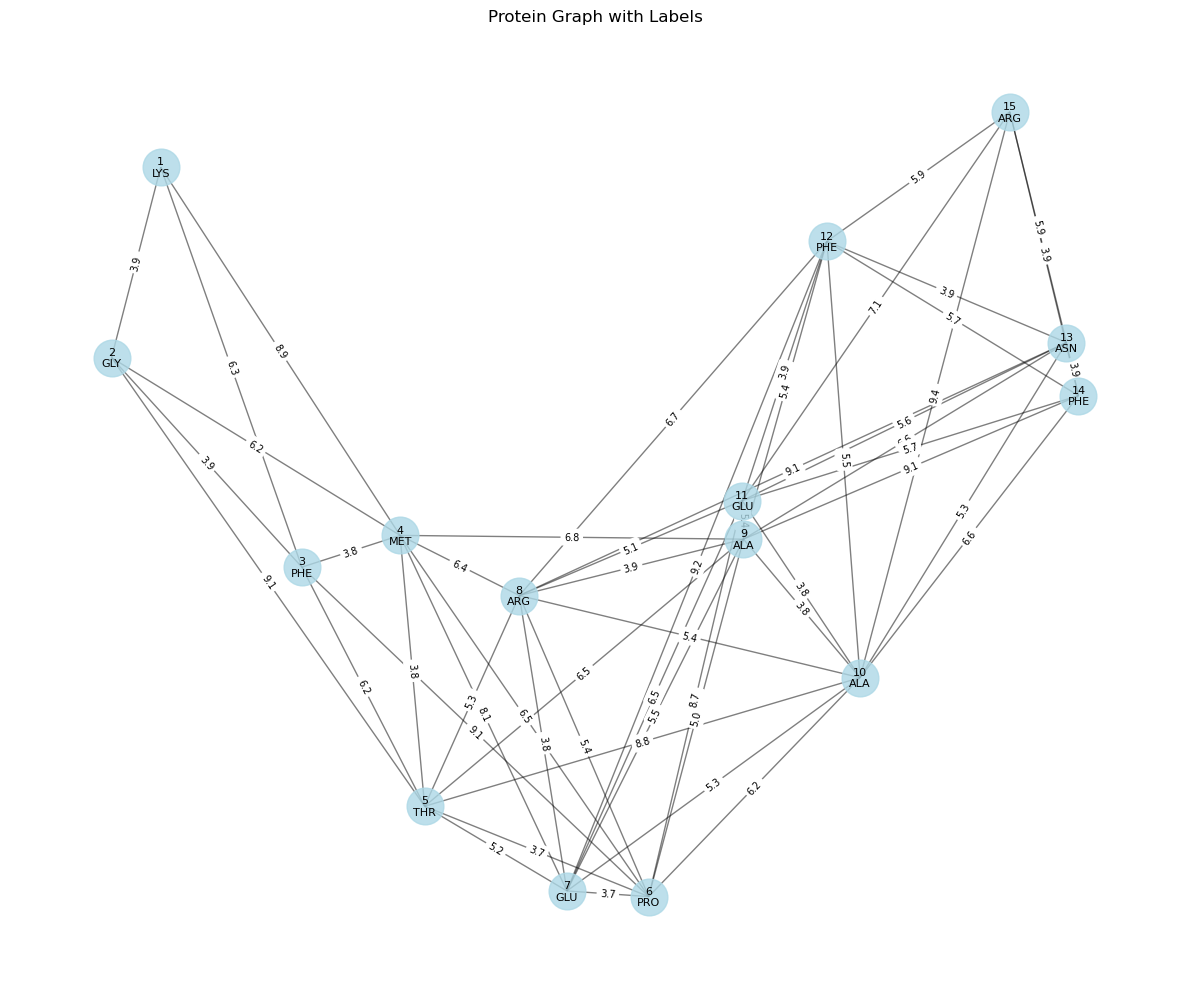

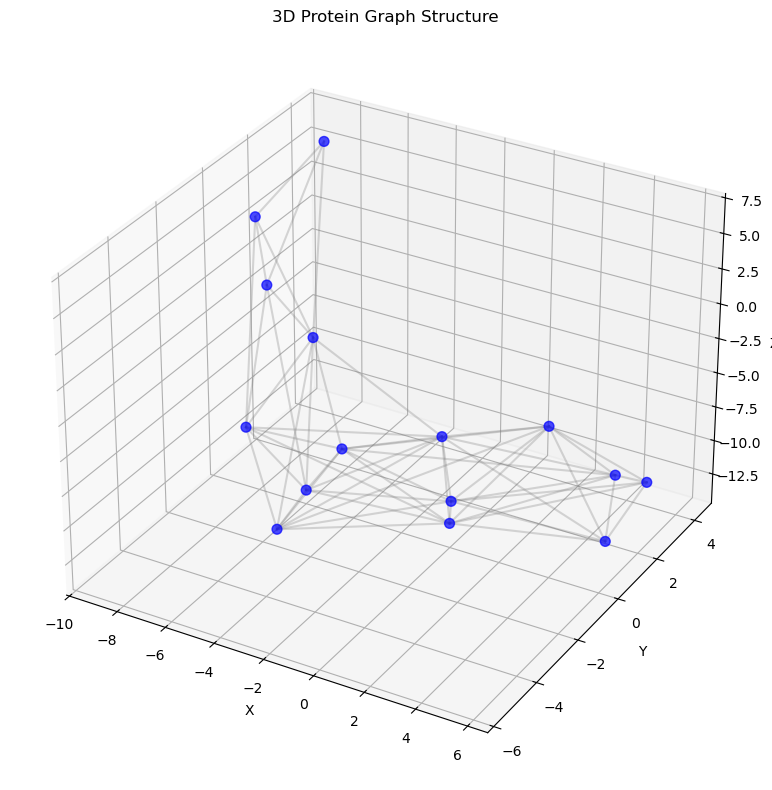

Number of nodes: 15
Number of edges: 54
Average degree: 7.20
Embedding shape: (1024,)


In [57]:
visualize_protein_graph_with_labels(G, residue_list)

In [58]:
def visualize_protein_subgraph(G, residue_list, start_residue=1, window_size=20):

    residue_ids = [res_id for res_id, _ in residue_list]
    subgraph_nodes = [node for node in G.nodes() if node in residue_ids[start_residue-1:start_residue-1+window_size]]
    subgraph = G.subgraph(subgraph_nodes)
    
    sub_residue_list = [(res_id, coord) for res_id, coord in residue_list if res_id in subgraph_nodes]
    
    visualize_protein_graph_with_labels(subgraph, sub_residue_list, 
                                        title=f"Protein Subgraph (Residues {start_residue}-{start_residue+window_size-1})")

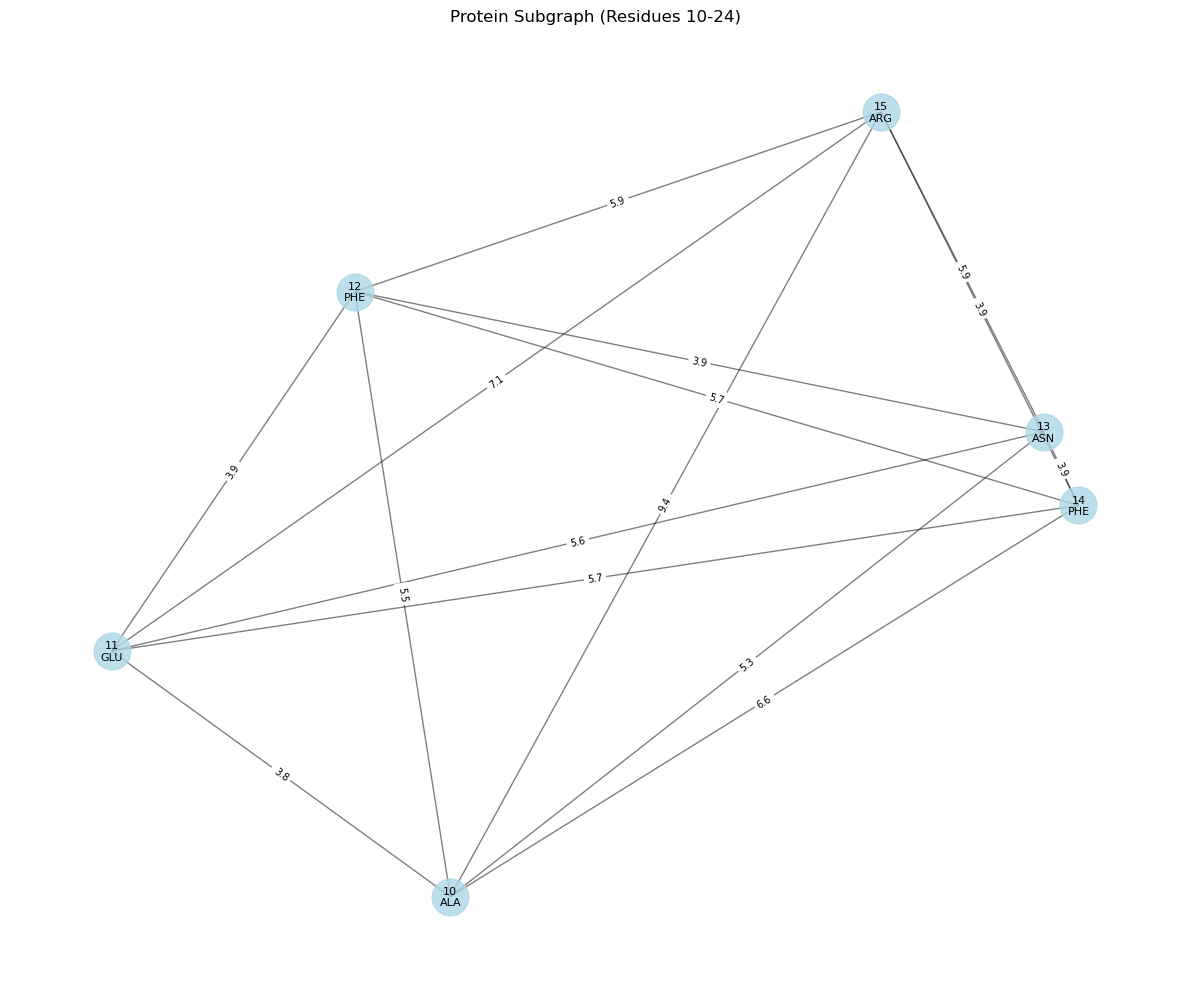

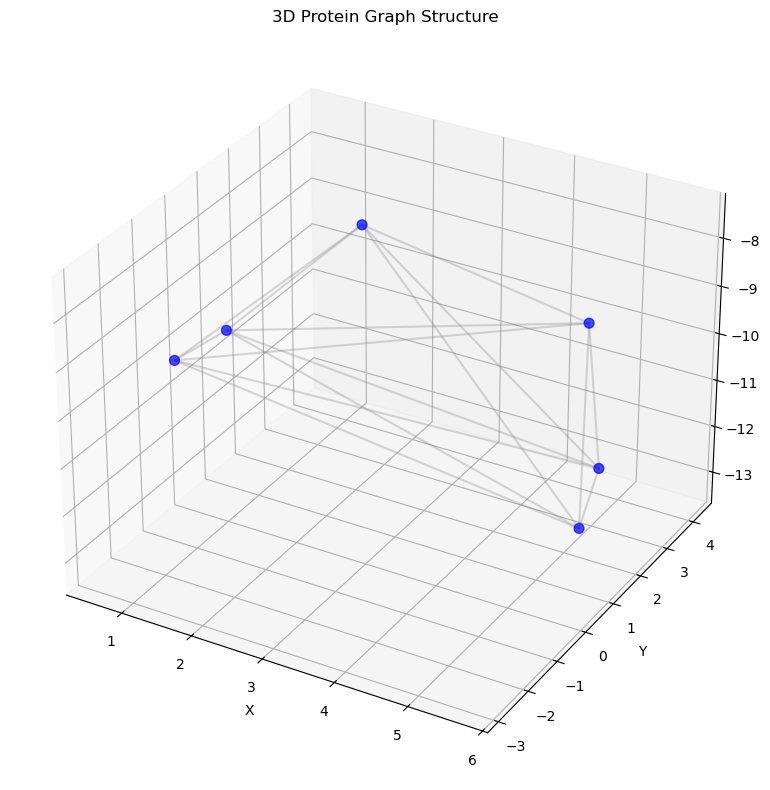

Number of nodes: 6
Number of edges: 15
Average degree: 5.00
Embedding shape: (1024,)


In [59]:

visualize_protein_subgraph(G, residue_list, start_residue=10, window_size=15)

In this version, ProtBERT embeddings attached as graph-level feature but we can use ProtBERT embeddings as node features.
We can use ProtBERT embeddings to calculate edge weight with incorporating both spatial distance and sequence based similarity